# **Image Classification using CNN**

## Notebook By => **Shyam Sundhar G**

In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruitsdatasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5544862%2F9174913%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240928%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240928T042559Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc6de411da9740bf35f0596d2a94e84df682517315e32af34a96753a42a94f8c9cbfe521faa8c37a7a2c89046222e05b12e94c485c4fd32e03f7e70d0f54a36e92289f59e604b80bb2695f2cbc239494d682d0d7046f6ead9266e328bf013eaccd05a13bf1907bbbe74f89466aee8f8f071d0041fdc1663f72b645e88e47f442f395b4d71c836d87364e0467b7fc1b9aeccb98a5c79202bcd840c75029068b3fce34d67e1c7540c2a193bdb747acec8e0d8daf1d4059cf715474185c806fc55153aef14b414802544dc4e069e41f77465536b3f122ee536434c0fbfd0aaf48ade6ee1237e2db20c3f292233cc4a785f4d426db776e873876521bfb332cee39c73'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2130894990 bytes downloaded
Downloaded and uncompressed: fruitsdatasets
Data source import complete.


In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [65]:
df_train_path='/kaggle/input/fruitsdatasets/Fruits_Vegetables/train'
df_test_path='/kaggle/input/fruitsdatasets/Fruits_Vegetables/test'
df_val_path='/kaggle/input/fruitsdatasets/Fruits_Vegetables/validation'

In [14]:
df_train=tf.keras.utils.image_dataset_from_directory(df_train_path,image_size=(180,180),validation_split=False)

Found 3115 files belonging to 36 classes.


In [15]:
df_name=(df_train.class_names)

In [16]:
df_test=tf.keras.utils.image_dataset_from_directory(df_test_path,validation_split=False)

Found 359 files belonging to 36 classes.


In [17]:
df_val=tf.keras.utils.image_dataset_from_directory(df_val_path,validation_split=False)

Found 351 files belonging to 36 classes.


In [18]:
import tensorflow as tf
import os

def load_and_check_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        return image
    except tf.errors.InvalidArgumentError:
        print(f"Invalid image file: {image_path}")
        return None

# Example usage within the data pipeline
df_train = tf.keras.utils.image_dataset_from_directory(
    df_train_path, image_size=(180, 180), validation_split=False
)
df_val = tf.keras.utils.image_dataset_from_directory(
    df_val_path, image_size=(180, 180), validation_split=False
)


Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


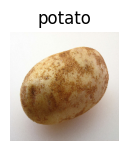

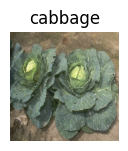

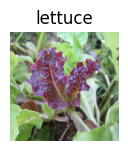

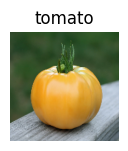

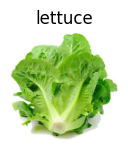

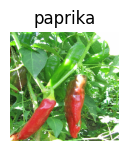

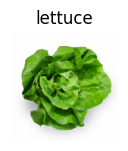

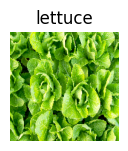

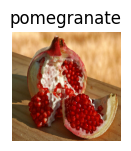

In [19]:
for img,label in df_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(df_name[label[i]])
        plt.axis("off")
        plt.show()

In [20]:
df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
model=Sequential([
    layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(df_name))
])

In [22]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [24]:
his=model.fit(df_train,validation_data=df_val,epochs=25)

Epoch 1/25
98/98 [==============================] - 16s 140ms/step - loss: 3.4851 - accuracy: 0.0597 - val_loss: 3.0761 - val_accuracy: 0.1453
Epoch 2/25
98/98 [==============================] - 14s 138ms/step - loss: 2.7847 - accuracy: 0.1949 - val_loss: 2.1482 - val_accuracy: 0.3504
Epoch 3/25
98/98 [==============================] - 14s 136ms/step - loss: 2.3496 - accuracy: 0.2921 - val_loss: 1.7767 - val_accuracy: 0.4815
Epoch 4/25
98/98 [==============================] - 14s 137ms/step - loss: 2.0263 - accuracy: 0.4074 - val_loss: 1.2326 - val_accuracy: 0.6581
Epoch 5/25
98/98 [==============================] - 14s 136ms/step - loss: 1.6243 - accuracy: 0.5213 - val_loss: 0.8523 - val_accuracy: 0.7578
Epoch 6/25
98/98 [==============================] - 14s 136ms/step - loss: 1.1733 - accuracy: 0.6536 - val_loss: 0.6428 - val_accuracy: 0.8376
Epoch 7/25
98/98 [==============================] - 14s 136ms/step - loss: 0.7567 - accuracy: 0.7698 - val_loss: 0.4440 - val_accuracy: 0.9117

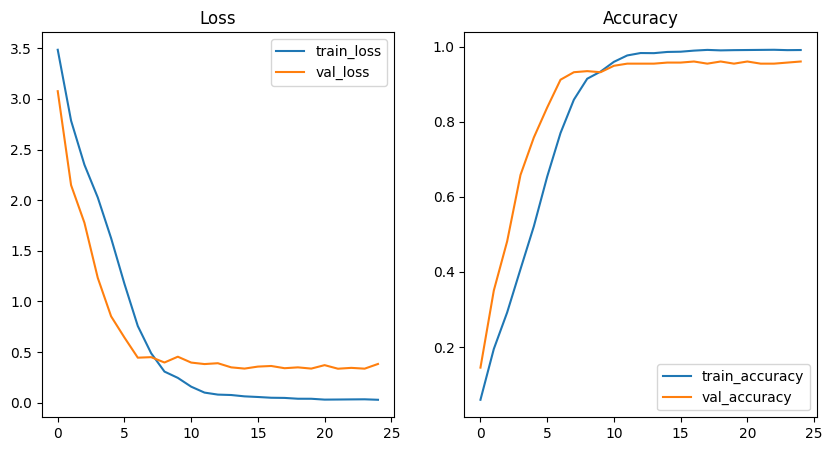

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(his.history['loss'],label='train_loss')
plt.plot(his.history['val_loss'],label='val_loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(his.history['accuracy'],label='train_accuracy')
plt.plot(his.history['val_accuracy'],label='val_accuracy')
plt.title("Accuracy")
plt.legend()

In [61]:
img='/content/images.jpeg';
image=tf.keras.utils.load_img(img,target_size=(180,180))
imgarr=tf.keras.utils.array_to_img(image)
imgbat=tf.expand_dims(image,0)

In [72]:
predict=model.predict(imgbat)
score=tf.nn.softmax(predict[0])
predicted_class=df_name[np.argmax(score)]
predicted_score=100*np.max(score)
print(f"Predicted class: {predicted_class}")
print(f"Predicted score: {predicted_score}")

1/1 [==============================] - 0s 30ms/step
Predicted class: paprika
Predicted score: 88.65070343017578
